In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader


# model used for MC-dropout
class BinaryClassifier(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size):
        super(BinaryClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.dropout1 = nn.Dropout(0.1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.dropout2 = nn.Dropout(0.1)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.dropout3 = nn.Dropout(0.1)
        self.fc4 = nn.Linear(hidden_size3, output_size)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = F.relu(self.fc3(x))
        x = self.dropout3(x)
        x = torch.sigmoid(self.fc4(x))  # Sigmoid activation for binary classification
        return x

In [30]:
# function that calculates the standard deviation,
def calculate_std(model, features):
    num_samples = 100
    mc_predictions = []
    with torch.no_grad():
        model.train()
        mc_predictions_batch = torch.zeros(num_samples, features.shape[0], 12) # 12 AU classes
        for i in range(num_samples):
            y_pred = model(features)
            # print(y_pred_val.shape)
            mc_predictions_batch[i] = y_pred.squeeze()
        mc_predictions.append(mc_predictions_batch)
    mc_predictions = torch.concat(mc_predictions, dim=1)
    
    std_predictions = mc_predictions.std(dim=0)
    std_predictions_mean = std_predictions.mean(dim=1)
    std_predictions_mean = std_predictions_mean.squeeze()
    std_predictions_mean = std_predictions_mean.view(1, -1, 1)
    return std_predictions_mean

In [51]:
import cv2
import numpy as np
import os
import torch
import timm

# fuction that takes in a video, and return its features
def generate_features(video_path):
    device = "cuda"
    
    model = timm.create_model('vit_base_patch16_224', pretrained=True)
    model = model.to(device)
    model.eval()
    
    def preprocess_frame(frame):
        frame = cv2.resize(frame, (224, 224), interpolation=cv2.INTER_AREA)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = torch.tensor(frame / 255.0, dtype=torch.float32)
        frame = (frame - torch.tensor([0.485, 0.456, 0.406])) / torch.tensor([0.229, 0.224, 0.225])
        frame = frame.permute(2, 0, 1).unsqueeze(0)  # Reshape to [1, 3, 224, 224]
        return frame
    
    cap = cv2.VideoCapture(video_path)
    frame_index = 0
    all_features=[]
    while cap.isOpened():
        ret, frame = cap.read()
        if ret:
            # Preprocess the frame
            input_tensor = preprocess_frame(frame)
    
            input_tensor = input_tensor.to(device)
    
            # Extract features
            with torch.no_grad():
                features = model.forward_features(input_tensor)
            
            all_features.append(features.cpu().numpy())
            # Save features to a file
            frame_index += 1
        else:
            break
    cap.release()
    features = torch.tensor(np.array(all_features))
    features = features.mean(axis=2, keepdims=False)
    features = features.permute(1, 0, 2)
    return features

In [52]:
video_path = "./video_blurred/53-30-360x480.mp4"
original_video_path = "./video_bipeng/53-30-360x480.mp4"
video_features = generate_features(video_path)
original_video_features = generate_features(original_video_path)

In [53]:
video_features.shape

torch.Size([1, 1053, 768])

In [55]:
original_video_features.shape

torch.Size([1, 1052, 768])

In [56]:
video_features = video_features.to(device)
original_video_features = original_video_features.to(device)

In [57]:
video_model = torch.load("./best_model_video.pt") # pre-trained video model using the previously defined model
video_features = video_features.squeeze()
video_std = calculate_std(video_model, video_features)
original_video_features = original_video_features.squeeze()
original_video_std = calculate_std(video_model, original_video_features)

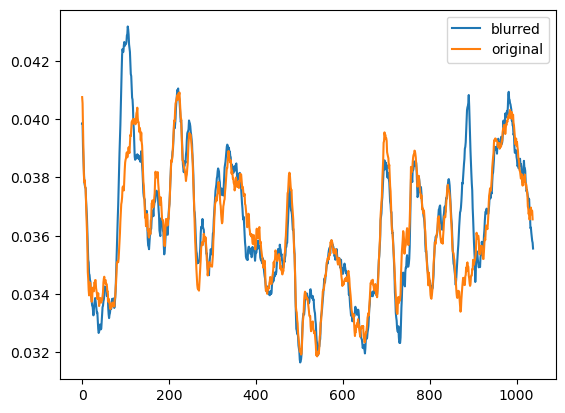

In [66]:
import matplotlib.pyplot as plt

window_size = 15

data = video_std.cpu().numpy()
smoothed_data = np.convolve(data, np.ones(window_size)/window_size, mode='valid')
plt.plot(smoothed_data, label="blurred")

original_data = original_video_std.cpu().numpy()
smoothed_original_data = np.convolve(original_data, np.ones(window_size)/window_size, mode='valid')
plt.plot(smoothed_original_data, label="original")
plt.legend()

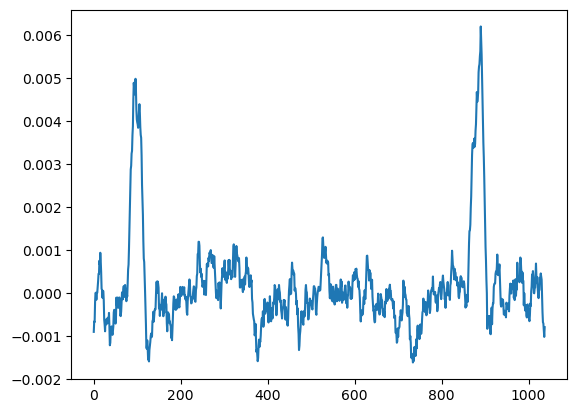

In [70]:
min_len = min(len(smoothed_data), len(smoothed_original_data))
plt.plot(smoothed_data[:min_len] - smoothed_original_data[:min_len])

In [2]:
def apply_mc_dropout_weight(vfeature, afeature, labels):
    vfeature, afeature = vfeature.to(device), afeature.to(device)
    video_model = torch.load("./best_model_video.pt")
    audio_model = torch.load("./audio_best_model.pt")
    
    vstd = calculate_std(video_model, vfeature, labels)
    astd = calculate_std(audio_model, afeature, labels)
    vstd, astd = vstd.to(device), astd.to(device)
    wv = (2 / vstd) / ((1 / vstd) + (1 / astd))
    wa = (2 / astd) / ((1 / vstd) + (1 / astd))
    nan_check = torch.isnan(wv)
    inf_check = torch.isinf(wv)
    assert not nan_check.any()
    assert not inf_check.any()
    nan_check = torch.isnan(wa)
    inf_check = torch.isinf(wa)
    assert not nan_check.any()
    assert not inf_check.any()
    wv = wv.view(1, -1, 1)
    wa = wa.view(1, -1, 1)
    vfeature = vfeature * wv
    afeature = afeature * wa
    return vfeature, afeature

In [4]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

device = "cuda"
def seq_feature_generation(video_feature, audio_feature, seq_len, pooling = "mean"):
    #video_feature : [1, 773, 768]
    #audio_feature : [1, 773, 1024]
    video_feature = video_feature.to(device)
    audio_feature = audio_feature.to(device)

    combined_feature = torch.cat([video_feature, audio_feature], dim=-1)
    max_seq = combined_feature.shape[1]
    #[1, max_seq, 1024 + 768]
    
    if max_seq < seq_len:
        # Pad both features to seq_len along the sequence dimension
        combined_sequences = F.pad(combined_feature, (0, 0, 0, seq_len - max_seq))
    else:
        num_complete_seqs = max_seq // seq_len
        combined_sequences = combined_feature[:,:num_complete_seqs*seq_len, :].view(-1, seq_len, combined_feature.shape[-1])
    #[-1, seq_len, combined_feature_size]
    return combined_sequences

class CustomDataset(Dataset):
    def __init__(self, video_features_dir, audio_features_dir, labels_dir):
        # audio (1, length, 1024)
        # video (length, 1, 768)

        self.samples = []

        # Get the list of filenames (without suffix) for features and labels
        video_features_files = {os.path.splitext(f)[0]: f for f in os.listdir(video_features_dir) if f.endswith('.pt')}
        audio_features_files = {os.path.splitext(f)[0]: f for f in os.listdir(audio_features_dir) if f.endswith('.pt')}
        labels_files = {os.path.splitext(f)[0]: f for f in os.listdir(labels_dir) if f.endswith('.txt')}

        # Find the intersection of filenames
        common_filenames = video_features_files.keys() & audio_features_files.keys() & labels_files.keys()

        # Load the data for the common filenames
        # cnt = 0
        for filename in common_filenames:
            # cnt += 1
            # if cnt == 10:
            #     break
            video_features_path = os.path.join(video_features_dir, video_features_files[filename])
            audio_features_path = os.path.join(audio_features_dir, audio_features_files[filename])
            labels_path = os.path.join(labels_dir, labels_files[filename])

            video_features = torch.load(video_features_path)
            video_features = video_features.permute(1, 0, 2) # (1, length, 768)
            audio_features = torch.load(audio_features_path)
            labels = np.loadtxt(labels_path, skiprows=1, delimiter=',')
            
            min_len = min(video_features.shape[1], audio_features.shape[1], len(labels))
            video_features = video_features[:, :min_len, :]
            audio_features = audio_features[:, :min_len, :]
            labels = torch.tensor(labels[:min_len])

            valid_indices = [i for i, label in enumerate(labels) if -1 not in label]
            video_features = video_features[:, valid_indices, :]
            audio_features = audio_features[:, valid_indices, :]
            labels = labels[valid_indices]

            video_features, audio_features = apply_mc_dropout_weight(video_features, audio_features, labels)
            
            seq_len = 10
            combined_sequences = seq_feature_generation(video_features, audio_features, seq_len)
            label_sequences = labels[:combined_sequences.shape[0] * seq_len].reshape(-1, seq_len, 12)

            self.trunk_size = 128  # Adjust this value as needed
            num_trunks = combined_sequences.shape[0] // self.trunk_size + 1

            # Split features and labels into trunks
            for i in range(0, num_trunks):
                start_idx = i * self.trunk_size
                end_idx = min(start_idx + self.trunk_size, combined_sequences.shape[0])
                if start_idx == end_idx:
                    break
                features_trunk = combined_sequences[start_idx:end_idx]
                labels_trunk = label_sequences[start_idx:end_idx]
                # print(features_trunk.shape)
                # print(labels_trunk.shape)
                self.samples.append((features_trunk, labels_trunk))
            
    
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

# Instantiate the dataset
VIDEO_FEATURES_FOLDER = "./video_feature_pooled"
AUDIO_FEATURES_FOLDER = "./features4"
LABELS_FOLDER = "./labels/AU_Detection_Challenge/Train_Set"
dataset = CustomDataset(VIDEO_FEATURES_FOLDER, AUDIO_FEATURES_FOLDER, LABELS_FOLDER)

# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

In [5]:
VAL_LABELS_FOLDER = "./labels/AU_Detection_Challenge/Validation_Set"
val_dataset = CustomDataset(VIDEO_FEATURES_FOLDER, AUDIO_FEATURES_FOLDER, VAL_LABELS_FOLDER)

# Create a DataLoader
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)

In [6]:
for batch_idx, (X, y) in enumerate(dataloader):
    # Train your model with the features (X) and labels (y)
    print(batch_idx, X.shape, y.shape)
    break

0 torch.Size([1, 128, 10, 1792]) torch.Size([1, 128, 10, 12])


In [13]:
import timm
from transformers import Wav2Vec2Processor, HubertModel

class ViTHuBERTTransformer_prepossed(nn.Module):
    def __init__(self, vit_base_model,
                 hubert_base_model,
                 num_classes,
                 nhead,
                 num_layers,
                small_dataset = True):
        super().__init__()

        self.vit = timm.create_model(vit_base_model, pretrained=True)

        #self.processor = Wav2Vec2Processor.from_pretrained(hubert_base_model)
        self.hubert = HubertModel.from_pretrained(hubert_base_model)

        if small_dataset:
            for param in self.vit.parameters():
                param.requires_grad = False
       
            for param in self.hubert.parameters():
                param.requires_grad = False
           
        print(self.vit.num_features + self.hubert.config.hidden_size)
        encoder_layer = nn.TransformerEncoderLayer(d_model = self.vit.num_features + self.hubert.config.hidden_size,
                                                  nhead = nhead,
                                                  dim_feedforward = (self.vit.num_features + self.hubert.config.hidden_size)//2,
                                                  batch_first = True)
        # print(encoder_layer.head_dim)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers = num_layers)

        # Classifier
        self.classifier = nn.Linear(self.vit.num_features + self.hubert.config.hidden_size, num_classes)
        self._init_transformer_weights()

    def _init_transformer_weights(self):
        # Initialize only the transformer encoder layers
        for layer in self.transformer_encoder.layers:
            for module in layer.modules():
                if isinstance(module, nn.Linear):
                    nn.init.xavier_uniform_(module.weight)
                    if module.bias is not None:
                        nn.init.constant_(module.bias, 0)
                # Optionally initialize other components like multi-head attention within the transformer layer
                # Depending on the PyTorch implementation, you may need to access sub-components directly

    def forward(self, combined_feature):

        transformer_output = self.transformer_encoder(combined_feature)

        logits = self.classifier(transformer_output.squeeze(1))
        return logits

In [14]:
model = ViTHuBERTTransformer_prepossed(
    vit_base_model = 'vit_base_patch16_224',
    hubert_base_model = "facebook/hubert-large-ls960-ft",
    num_classes = 12,
    nhead = 16,
    num_layers = 18,
    small_dataset = True
)

model = model.to(device)

Some weights of HubertModel were not initialized from the model checkpoint at facebook/hubert-large-ls960-ft and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


1792


In [15]:
def evaluate(model, dataloader, loss_fn, device):
    model.eval()
    loss_cumulative = 0.
    eval_labels = []
    eval_preds = []
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Evaluate"):
            inputs, labels = inputs.squeeze().to(device), labels.squeeze().to(device)
            outputs = model(inputs)
            # print(outputs)
            # assert False
            loss = loss_fn(outputs, labels)
            loss_cumulative += loss.item()
            # print(loss_cumulative)
            preds = torch.sigmoid(outputs) if not hasattr(loss_fn, 'activation') else outputs
            preds = (preds > 0.5).int()
            eval_labels.append(labels.cpu().numpy().reshape(-1,12))
            eval_preds.append(preds.cpu().numpy().reshape(-1,12))
    eval_labels = np.concatenate(eval_labels, axis=0)
    eval_preds = np.concatenate(eval_preds, axis=0)
    print(eval_labels.shape, eval_preds.shape)
    eval_f1_score = f1_score(eval_labels, eval_preds, average='macro')
    return loss_cumulative / len(dataloader), eval_f1_score

In [16]:
def loglinspace(rate, step, end=None):
    t = 0
    while end is None or t <= end:
        yield t
        t = int(t + 1 + step * (1 - math.exp(-t * rate / step)))

In [17]:
! rm ./vithubertformer.torch

In [18]:
import time
from tqdm import tqdm
from sklearn.metrics import f1_score
import math


def train(model, optimizer, dataloader_train, dataloader_valid, loss_fn,
             max_iter=101, scheduler=None, device="cpu"):
    model.to(device = device, dtype=torch.float32)
    print(device)
    checkpoint_generator = loglinspace(0.3, 5)
    checkpoint = next(checkpoint_generator)
    start_time = time.time()
    run_name = "vithubertformer"
    try:
        model.load_state_dict(torch.load(run_name + '.torch')['state'])
    except:
        results = {}
        history = []
        s0 = 0
    else:
        print('read torch history')
        results = torch.load(run_name + '.torch')
        history = results['history']
        s0 = history[-1]['step'] + 1
       
   
    for step in range(max_iter):
        if step == 0:
            for i in range(1):
                valid_avg_loss, val_f1_score = evaluate(model, dataloader_valid, loss_fn, device)
                print(f'{i}',f'valid_avg_loss before training: {valid_avg_loss:8.4f}', f'val_f1_score before training: , {val_f1_score:8.4f}')

       
        model.train()
        loss_cumulative = 0.

        for inputs, labels in tqdm(dataloader_train, desc="Training"):
            inputs, labels = inputs.squeeze().to(device), labels.squeeze().to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            loss_cumulative += loss.item()
        print('Training loss: ',loss_cumulative)

        wall = time.time() - start_time
        if step == checkpoint:
            checkpoint = next(checkpoint_generator)
            assert checkpoint > step

            valid_avg_loss, val_f1_score = evaluate(model, dataloader_valid, loss_fn, device)

            history.append({
                'step': s0 + step,
                'wall': wall,
                'batch': {
                    'loss': loss.item(),
                },
                'valid': {
                    'loss': valid_avg_loss,
                },
            })

            results = {
                'history': history,
                'state': model.state_dict()
            }

            print(f"epoch {step + 1:4d}   " +
                  f"valid loss mse= {valid_avg_loss:8.4f}   " +
                  f"wall = {time.strftime('%H:%M:%S', time.gmtime(wall))}  " +
                  f"val_f1_score = {val_f1_score:8.4f}  " #+
                  # f"train_f1_score = {train_f1_score:8.4f}  "
                 )

            with open(run_name + '.torch', 'wb') as f:
                torch.save(results, f)

        if scheduler is not None:
            scheduler.step(valid_avg_loss)
            last_lr = scheduler.get_last_lr()
            print("Last learning rate:", last_lr)

loss_function = torch.nn.CrossEntropyLoss()
opt = torch.optim.AdamW(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min', factor=0.5, patience=2)
train(model, opt, dataloader, val_dataloader, loss_function,
             max_iter=10, scheduler=scheduler, device=device)

cuda


Evaluate: 100%|██████████| 404/404 [00:18<00:00, 22.36it/s]


(445350, 12) (445350, 12)
0 valid_avg_loss before training:   4.8725 val_f1_score before training: ,   0.1130


Training: 100%|██████████| 1189/1189 [03:51<00:00,  5.14it/s]


Training loss:  7222.1831084509195


Evaluate: 100%|██████████| 404/404 [00:17<00:00, 22.57it/s]


(445350, 12) (445350, 12)
epoch    1   valid loss mse=   6.1450   wall = 00:04:09  val_f1_score =   0.1987  
Last learning rate: [0.01]


Training: 100%|██████████| 1189/1189 [03:50<00:00,  5.15it/s]


Training loss:  5853.268898249763


Evaluate: 100%|██████████| 404/404 [00:17<00:00, 22.62it/s]


(445350, 12) (445350, 12)
epoch    2   valid loss mse=   5.5262   wall = 00:08:29  val_f1_score =   0.2575  
Last learning rate: [0.01]


Training: 100%|██████████| 1189/1189 [03:50<00:00,  5.16it/s]


Training loss:  6068.068687400275


Evaluate: 100%|██████████| 404/404 [00:17<00:00, 22.66it/s]


(445350, 12) (445350, 12)
epoch    3   valid loss mse=   6.0667   wall = 00:12:40  val_f1_score =   0.1696  
Last learning rate: [0.01]


Training: 100%|██████████| 1189/1189 [03:50<00:00,  5.15it/s]


Training loss:  5873.9597535712965


Evaluate: 100%|██████████| 404/404 [00:17<00:00, 22.67it/s]


(445350, 12) (445350, 12)
epoch    4   valid loss mse=   5.0750   wall = 00:16:53  val_f1_score =   0.2393  
Last learning rate: [0.01]


Training: 100%|██████████| 1189/1189 [03:50<00:00,  5.16it/s]


Training loss:  5909.806614062387


Evaluate: 100%|██████████| 404/404 [00:17<00:00, 22.64it/s]


(445350, 12) (445350, 12)
epoch    5   valid loss mse=   5.1507   wall = 00:21:16  val_f1_score =   0.2200  
Last learning rate: [0.01]


Training: 100%|██████████| 1189/1189 [03:51<00:00,  5.15it/s]


Training loss:  5653.502777526783
Last learning rate: [0.01]


Training: 100%|██████████| 1189/1189 [03:50<00:00,  5.15it/s]


Training loss:  5672.889307306647


Evaluate: 100%|██████████| 404/404 [00:17<00:00, 22.66it/s]


(445350, 12) (445350, 12)
epoch    7   valid loss mse=   5.3867   wall = 00:29:20  val_f1_score =   0.2393  
Last learning rate: [0.005]


Training: 100%|██████████| 1189/1189 [03:51<00:00,  5.15it/s]


Training loss:  5862.551954268698
Last learning rate: [0.005]


Training: 100%|██████████| 1189/1189 [03:50<00:00,  5.15it/s]


Training loss:  5604.234427226776


Evaluate: 100%|██████████| 404/404 [00:17<00:00, 22.67it/s]


(445350, 12) (445350, 12)
epoch    9   valid loss mse=   5.0344   wall = 00:37:23  val_f1_score =   0.1966  
Last learning rate: [0.005]


Training: 100%|██████████| 1189/1189 [03:50<00:00,  5.15it/s]

Training loss:  5572.10030650949
Last learning rate: [0.005]
